# Proyecto Sweet Lift Taxi Company

# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Carga y preparación de datos:

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import time
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('taxi.csv')

In [3]:
print("📦 Columnas y tipos de datos:\n", df.dtypes)
print("\n🔁 Duplicados encontrados:", df.duplicated().sum())
print("\n🧱 Valores nulos por columna:\n", df.isna().sum())
print("\n📊 Estadísticas descriptivas generales:\n", df.describe(include='all'))

📦 Columnas y tipos de datos:
 datetime      object
num_orders     int64
dtype: object

🔁 Duplicados encontrados: 0

🧱 Valores nulos por columna:
 datetime      0
num_orders    0
dtype: int64

📊 Estadísticas descriptivas generales:
                    datetime    num_orders
count                 26496  26496.000000
unique                26496           NaN
top     2018-08-31 21:10:00           NaN
freq                      1           NaN
mean                    NaN     14.070463
std                     NaN      9.211330
min                     NaN      0.000000
25%                     NaN      8.000000
50%                     NaN     13.000000
75%                     NaN     19.000000
max                     NaN    119.000000


In [4]:
# 1. Convertimos la columna 'datetime' a tipo datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# 2. Ordenamos por la columna de tiempo
df = df.sort_values('datetime')

# 3. Establecemos 'datetime' como índice
df = df.set_index('datetime')

# 4. Remuestreamos a intervalos de 1 hora, sumando pedidos por cada hora
df_hourly = df.resample('1H').sum()

# 5. Visualizamos las primeras filas
print(df_hourly.head())


                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43


C:\Users\Pablo Sebastian\AppData\Local\Temp\ipykernel_19856\310052558.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('1H').sum()


In [6]:
#Verificamos que no hayan nulos
df_hourly.isnull().sum()


num_orders    0
dtype: int64

## Análisis

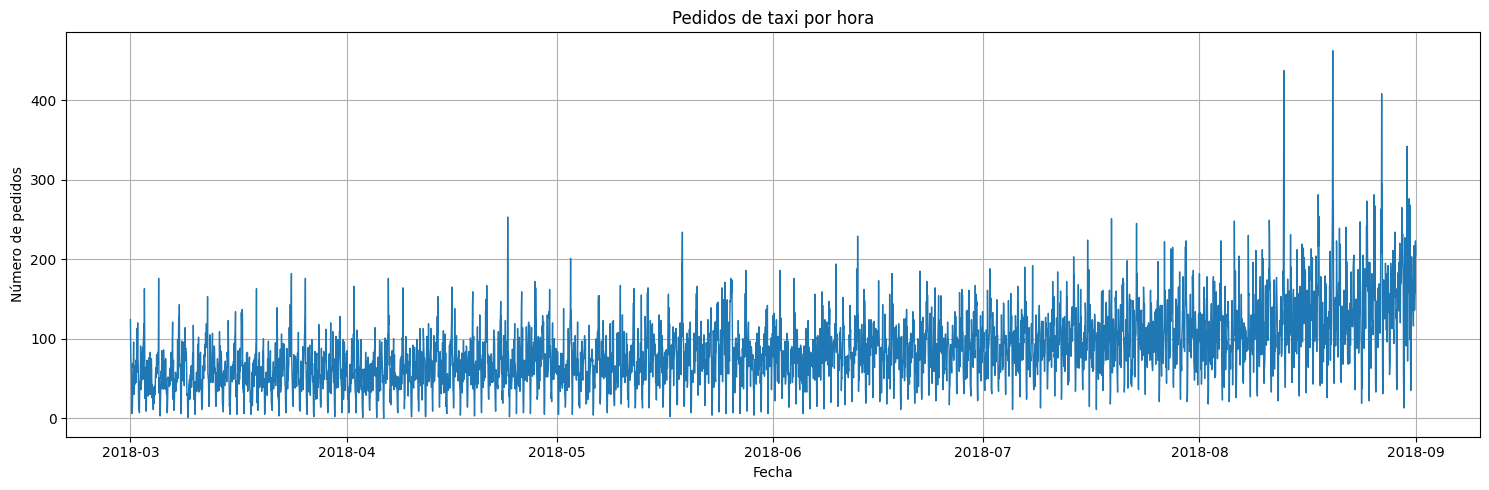

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(df_hourly.index, df_hourly['num_orders'], color='tab:blue', linewidth=1)
plt.title('Pedidos de taxi por hora')
plt.xlabel('Fecha')
plt.ylabel('Número de pedidos')
plt.grid(True)
plt.tight_layout()
plt.show()


Desde marzo hasta septiembre de 2018, se observa una tendencia ascendente en la cantidad de pedidos por hora. Esto significa que la demanda está aumentando con el tiempo. Tambien hay fluctuaciones horarias grandes y algunos picos extremos (por encima de 400 pedidos).

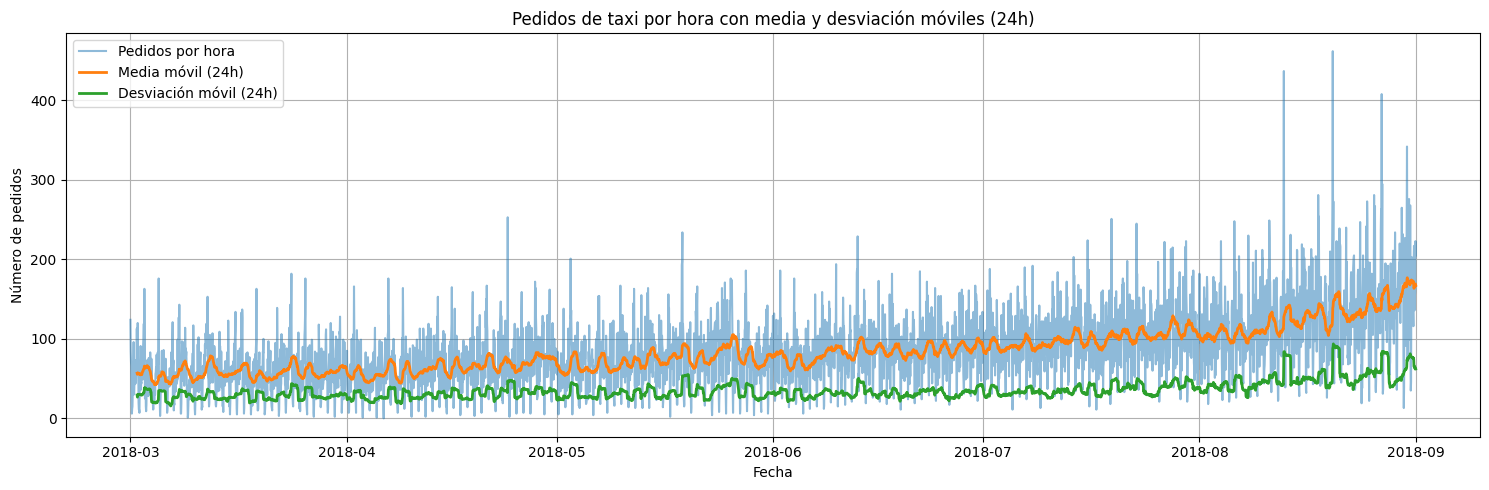

In [10]:
# Para ver con mayor claridad realizare un promedio movil
# Creamos columnas de media y desviación estándar móviles (ventana de 24 horas)
df_hourly['rolling_mean_24h'] = df_hourly['num_orders'].rolling(window=24).mean()
df_hourly['rolling_std_24h'] = df_hourly['num_orders'].rolling(window=24).std()

# Graficamos la serie junto con la media móvil
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(df_hourly['num_orders'], label='Pedidos por hora', alpha=0.5)
plt.plot(df_hourly['rolling_mean_24h'], label='Media móvil (24h)', linewidth=2)
plt.plot(df_hourly['rolling_std_24h'], label='Desviación móvil (24h)', linewidth=2)
plt.title('Pedidos de taxi por hora con media y desviación móviles (24h)')
plt.xlabel('Fecha')
plt.ylabel('Número de pedidos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Debido a la no estacionariedad, es esencial crear features temporales (como hora, día, semana, etc.) para capturar patrones de comportamiento sin necesidad de transformar directamente la serie.

## Ingenieria de características

In [11]:
# Copiamos el DataFrame para mantener df_hourly limpio
df_features = df_hourly.copy()

# Creamos las variables temporales
df_features['hour'] = df_features.index.hour                      # Hora del día (0-23)
df_features['day_of_week'] = df_features.index.dayofweek          # Día de la semana (0=Lunes, 6=Domingo)
df_features['day_of_year'] = df_features.index.dayofyear          # Día del año (1-365)
df_features['month'] = df_features.index.month                    # Mes (1-12)
df_features['is_weekend'] = df_features['day_of_week'].isin([5, 6]).astype(int)  # Sábado o domingo

# Verificamos
print(df_features.head())


                     num_orders  rolling_mean_24h  rolling_std_24h  hour  \
datetime                                                                   
2018-03-01 00:00:00         124               NaN              NaN     0   
2018-03-01 01:00:00          85               NaN              NaN     1   
2018-03-01 02:00:00          71               NaN              NaN     2   
2018-03-01 03:00:00          66               NaN              NaN     3   
2018-03-01 04:00:00          43               NaN              NaN     4   

                     day_of_week  day_of_year  month  is_weekend  
datetime                                                          
2018-03-01 00:00:00            3           60      3           0  
2018-03-01 01:00:00            3           60      3           0  
2018-03-01 02:00:00            3           60      3           0  
2018-03-01 03:00:00            3           60      3           0  
2018-03-01 04:00:00            3           60      3           0 

In [12]:
# Lag features: valores pasados
df_features['lag_1'] = df_features['num_orders'].shift(1)
df_features['lag_24'] = df_features['num_orders'].shift(24)
df_features['lag_168'] = df_features['num_orders'].shift(168)  # 168 = 24*7 = 1 semana

# Ventanas móviles pasadas (rolling windows con shift)
df_features['rolling_mean_3'] = df_features['num_orders'].shift(1).rolling(window=3).mean()
df_features['rolling_mean_24'] = df_features['num_orders'].shift(1).rolling(window=24).mean()
df_features['rolling_std_24'] = df_features['num_orders'].shift(1).rolling(window=24).std()


In [13]:
# 1. Eliminamos filas con valores nulos generados por lags y rolling
df_model = df_features.dropna()

# 2. Definimos la variable objetivo y las features
target = 'num_orders'
features = df_model.columns.difference([target])  # todas menos la target

X = df_model[features]
y = df_model[target]

# 3. División temporal 90% entrenamiento, 10% prueba
split_index = int(len(df_model) * 0.9)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Verificamos las formas
print(f'Tamaño entrenamiento: {X_train.shape}, Tamaño prueba: {X_test.shape}')


Tamaño entrenamiento: (3823, 13), Tamaño prueba: (425, 13)


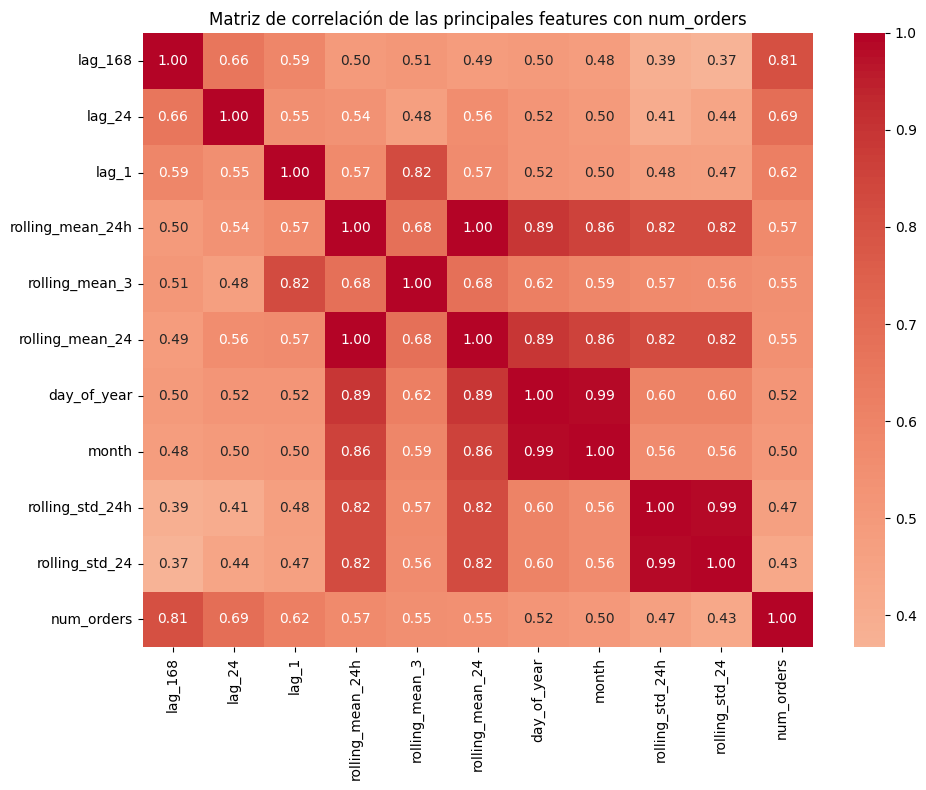

In [ ]:
# Calculamos correlaciones
corr_matrix = df_model.corr(numeric_only=True)

# Ordenamos de mayor a menor relación con num_orders
corr_target = corr_matrix['num_orders'].sort_values(ascending=False)

# Mostramos top 10 features más correlacionadas (sin incluir la diagonal)
top_features = corr_target[1:11].index  # Excluye num_orders
plt.figure(figsize=(10, 8))
sns.heatmap(df_model[top_features.tolist() + ['num_orders']].corr(), 
            annot=True, fmt=".2f", cmap="coolwarm", center=0)

plt.title('Matriz de correlación de las principales features con num_orders')
plt.tight_layout()
plt.show()


Observamos las caracteristicas que mayor coorelacion tengan, ya sea negativa o positiva, ya que seran las mas relevantes en el modelo despues.

Las variables con mayor correlación con el número de pedidos (num_orders) son los lags temporales, especialmente lag_168 (una semana atrás), lag_24 (un día atrás) y lag_1 (una hora atrás), lo que confirma patrones semanales y diarios en la demanda. También destacan los promedios móviles (rolling_mean_24h y rolling_mean_3) como buenos predictores del comportamiento reciente. Estas variables serán fundamentales en el entrenamiento del modelo, ya que reflejan la memoria y la dinámica temporal de la serie. Aunque algunas features presentan colinealidad (como day_of_year y month), no representan un problema para modelos como Random Forest o Gradient Boosting.

## Prueba

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Entrenamos el modelo con hiperparámetros base
model_rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# 2. Ajustamos el modelo a los datos
model_rf.fit(X_train, y_train)

# 3. Predecimos sobre el conjunto de prueba
y_pred = model_rf.predict(X_test)

# 4. Calculamos el RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE en el conjunto de prueba: {rmse:.2f}")


RMSE en el conjunto de prueba: 43.58


Ya cumplimos con le obj del proyecto, sin emnargo quiero optimizar aun mas el resultado.

In [17]:
# Nuevo modelo con hiperparámetros ajustados
model_rf_tuned = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)

# Entrenamiento
model_rf_tuned.fit(X_train, y_train)

# Predicciones
y_pred_tuned = model_rf_tuned.predict(X_test)

# Evaluación
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
print(f"RMSE del modelo ajustado: {rmse_tuned:.2f}")


RMSE del modelo ajustado: 40.59


Logramos bajar 3% al resultado, es decir ahora es mas acertivo. Lo dejaremos ahi, sin embargo, ahora graficare los resultados de prueba con los esperados del modelo para entender graficamente el resultado.

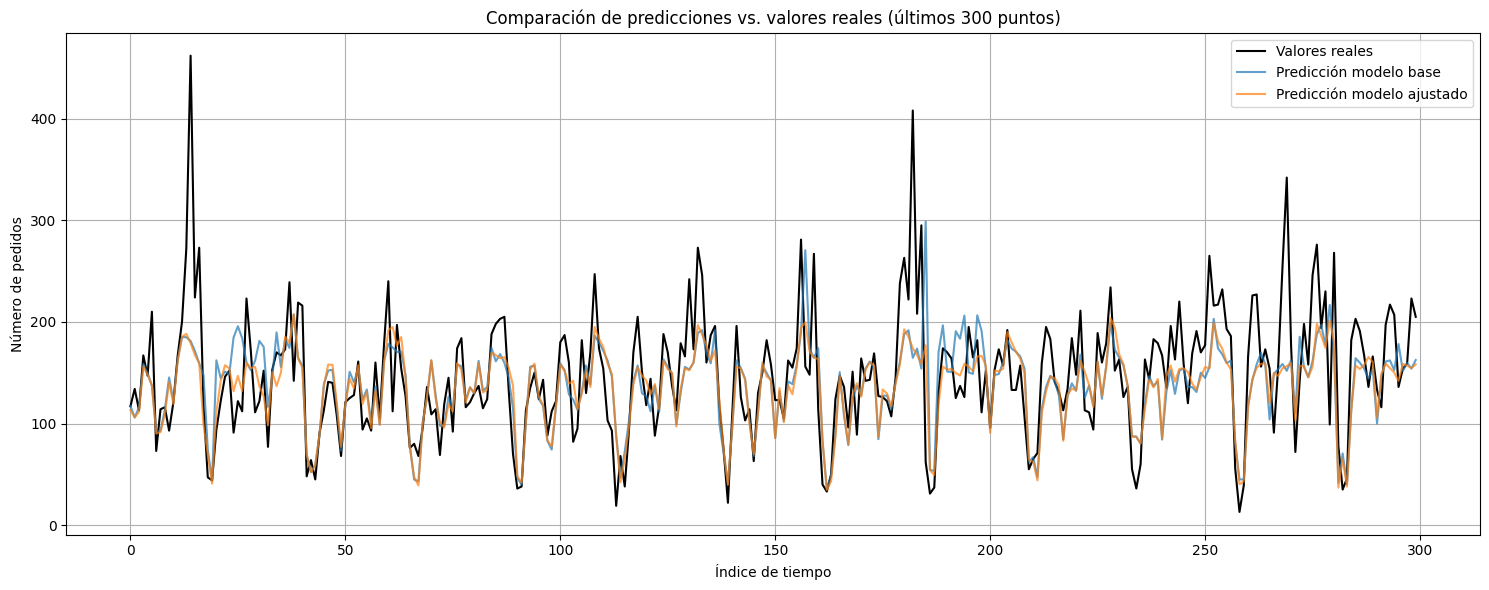

In [ ]:
# Definimos cuántos puntos mostrar
n = 300  # puedes ajustar según visibilidad

plt.figure(figsize=(15, 6))

plt.plot(y_test.values[-n:], label='Valores reales', color='black')
plt.plot(y_pred[-n:], label='Predicción modelo base', alpha=0.7)
plt.plot(y_pred_tuned[-n:], label='Predicción modelo ajustado', alpha=0.7)

plt.title('Comparación de predicciones vs. valores reales (últimos 300 puntos)')
plt.xlabel('Índice de tiempo')
plt.ylabel('Número de pedidos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [x]  	
Los datos han sido descargados y preparados.
- [x]  Se ha realizado el paso 2: los datos han sido analizados
- [x]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [x]  Se han evaluado los modelos. Se expuso una conclusión
- [x] La *RECM* para el conjunto de prueba no es más de 48